In [3]:
from src.visualizer.painter import Plot, Font, plt

## Painter Workspace

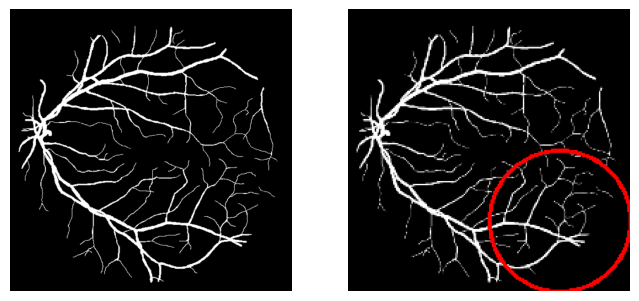

In [4]:
from src.utils.image_utils import ImageDrawer
from PIL import Image

image = Image.open("data/DRIVE/training/1st_manual/21.png").convert(mode="RGB")
image = image.resize((512, 512))

size = (100, 100)
xy = (100, 100)
ratio = 2
region = (*xy, *(xy[0] + size[0], xy[1] + size[1]))
resize = (size[0] * ratio, size[1] * ratio)
drawer = ImageDrawer(image).resize(resize)
center = (region[0] + region[2]) // 2, (region[1] + region[3]) // 2
radius = min(size) // 2
# o = drawer.draw_box(region, thickness=1).finish_as_opencv()
o = drawer.draw_circle(center, radius=radius, thickness=2).finish_as_opencv()

Plot(1, 2).subplot().image(image).complete().subplot().image(o).complete().show()

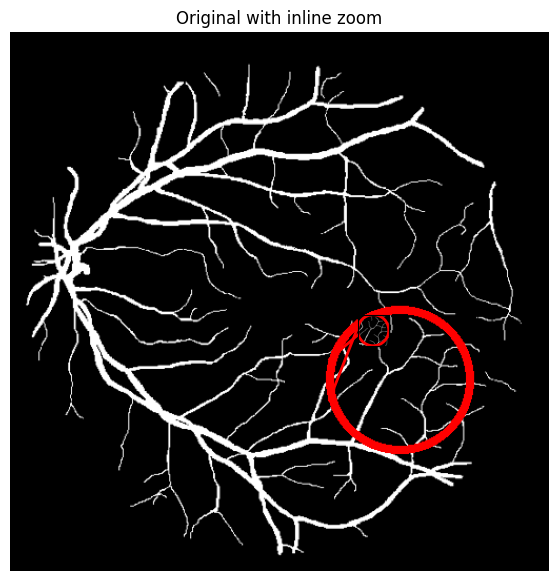

In [6]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle, ConnectionPatch
import math

img = (
    Image.open("data/DRIVE/training/1st_manual/21.png")
    .convert("RGB")
    .resize((512, 512))
)

# ROI 参数（可调）
center = (370, 330)  # (x, y)
box_size = 140
zoom = 2

half = box_size // 2
x1, y1 = center[0] - half, center[1] - half
x2, y2 = center[0] + half, center[1] + half

# 防止越界
x1, y1 = max(x1, 0), max(y1, 0)
x2, y2 = min(x2, img.width), min(y2, img.height)

# 在原图上画红圈
highlight = img.copy()
draw = ImageDraw.Draw(highlight)
draw.ellipse([x1, y1, x2, y2], outline="red", width=8)

# 裁剪并放大
patch = img.crop((x1, y1, x2, y2)).resize(((x2 - x1) * zoom, (y2 - y1) * zoom))

fig, ax = plt.subplots(figsize=(8, 7))
ax.imshow(highlight)
ax.set_title("Original with inline zoom")
ax.axis("off")

# 放大图位置：固定贴在 ROI 左侧，纵向与 ROI 对齐
inset_size = 0.24  # 相对主图宽高的比例
bx = center[0] / img.width
ay = 1 - center[1] / img.height  # axes 归一化 y（0,0 在左下）
px = max(bx - inset_size - 0.02, 0.02)
py = min(max(ay - inset_size / 2, 0.02), 0.98 - inset_size)

axins = inset_axes(
    ax,
    width=f"{inset_size * 100}%",
    height=f"{inset_size * 100}%",
    bbox_to_anchor=(px, py, inset_size, inset_size),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins.imshow(patch)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlim(0, patch.width)
axins.set_ylim(patch.height, 0)

# 放大视窗裁成圆形并描边
clip_circle = Circle(
    (patch.width / 2, patch.height / 2), patch.width / 2, transform=axins.transData
)
axins.set_clip_path(clip_circle)
axins.add_patch(
    Circle(
        (patch.width / 2, patch.height / 2),
        patch.width / 2,
        fill=False,
        edgecolor="red",
        linewidth=2,
    )
)

# 梯形引导：两条连线连接主图圆与放大圆（放大圆固定在左侧）
main_r = (x2 - x1) / 2
main_c = (center[0], center[1])
base = math.pi  # 指向左
angle_delta = math.radians(16)
angles_main = [base + angle_delta, base - angle_delta]
angles_zoom = angles_main

main_pts = [
    (main_c[0] + main_r * math.cos(a), main_c[1] + main_r * math.sin(a))
    for a in angles_main
]
zoom_pts = [
    (
        patch.width / 2 + patch.width / 2 * math.cos(a),
        patch.height / 2 - patch.height / 2 * math.sin(a),
    )
    for a in angles_zoom
]

for p_main, p_zoom in zip(main_pts, zoom_pts):
    con = ConnectionPatch(
        xyA=p_main,
        xyB=p_zoom,
        coordsA="data",
        coordsB="data",
        axesA=ax,
        axesB=axins,
        color="red",
        linewidth=2,
    )
    ax.add_artist(con)

plt.show()

## Report Generator Usage Example

This section demonstrates how to use the comprehensive report generator tool to:
1. Collect training/inference data
2. Generate statistical charts
3. Highlight images
4. Export to LaTeX format


In [7]:
from tools.report_generator import ReportGenerator, ImageInfo, TableInfo
from pathlib import Path
import pandas as pd

# Initialize report generator
base_dir = Path(".")
output_dir = Path("./reports")
latex_output = Path("./reports/report.tex")

generator = ReportGenerator(
    base_dir=base_dir, output_dir=output_dir, latex_output=latex_output
)

FileNotFoundError: [Errno 2] No such file or directory: 'reports/reports/training_curves.png'

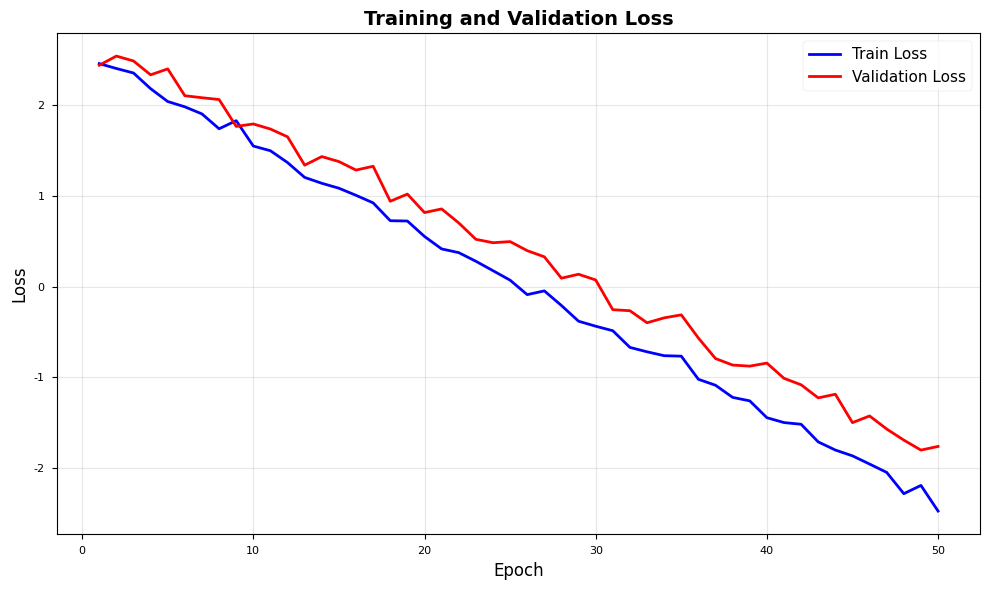

In [9]:
# Example 1: Generate training report from metrics
# This will collect training data and generate curves
# Supports JSON, CSV, and Parquet formats

# Option 1: From metrics JSON file
# generator.generate_training_report(metrics_file="runs/experiment/results.json")

# Option 2: From metrics CSV file
# generator.generate_training_report(metrics_file="runs/experiment/metrics.csv")

# Option 3: From metrics Parquet file
# generator.generate_training_report(metrics_file="runs/experiment/metrics.parquet")

# Option 4: From recovery directory (automatically detects JSON/CSV/Parquet)
# generator.generate_training_report(recovery_dir="runs/experiment/recovery")

# For demonstration, let's create some sample data
import numpy as np

# Generate sample training curves
train_losses = [2.5 - i * 0.1 + np.random.normal(0, 0.05) for i in range(50)]
val_losses = [2.6 - i * 0.09 + np.random.normal(0, 0.08) for i in range(50)]

# Plot training curves
curve_path = generator.plotter.plot_training_curves(
    train_losses=train_losses,
    val_losses=val_losses,
    title="Training and Validation Loss",
    save_path=output_dir / "training_curves.png",
)

print(f"Training curves saved to: {curve_path}")

# Add to report
generator.images.append(
    ImageInfo(
        path=curve_path,
        caption="Training and validation loss curves over 50 epochs",
        label="fig:training_curves",
    )
)

FileNotFoundError: [Errno 2] No such file or directory: 'reports/reports/metrics_comparison.png'

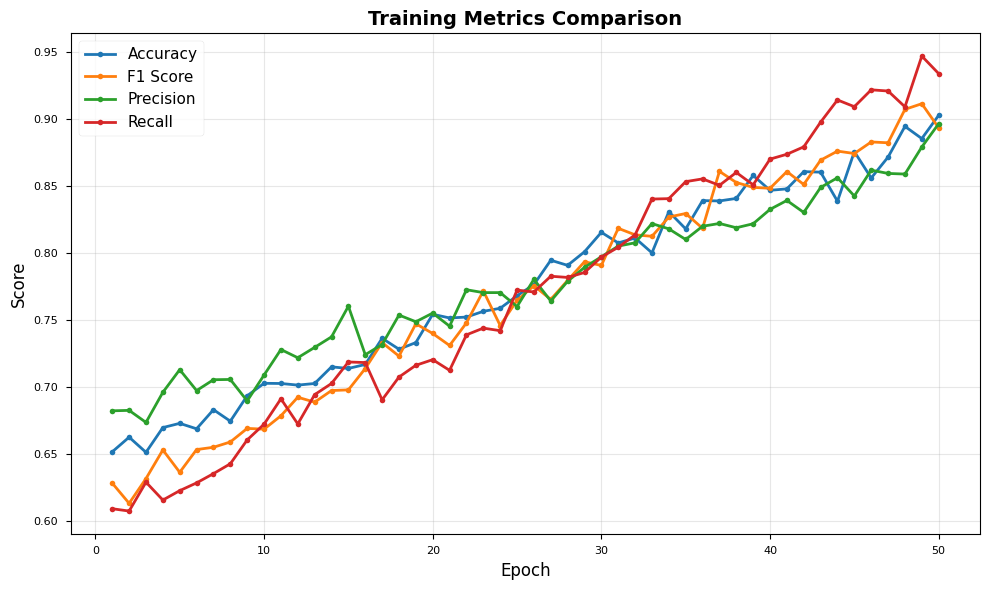

In [10]:
# Example 2: Generate metrics comparison chart
metrics_data = {
    "Accuracy": [0.65 + i * 0.005 + np.random.normal(0, 0.01) for i in range(50)],
    "F1 Score": [0.62 + i * 0.006 + np.random.normal(0, 0.01) for i in range(50)],
    "Precision": [0.68 + i * 0.004 + np.random.normal(0, 0.01) for i in range(50)],
    "Recall": [0.60 + i * 0.007 + np.random.normal(0, 0.01) for i in range(50)],
}

metrics_path = generator.plotter.plot_metrics_comparison(
    metrics_data=metrics_data,
    title="Training Metrics Comparison",
    save_path=output_dir / "metrics_comparison.png",
)

print(f"Metrics comparison saved to: {metrics_path}")

generator.images.append(
    ImageInfo(
        path=metrics_path,
        caption="Comparison of different metrics during training",
        label="fig:metrics_comparison",
    )
)

In [ ]:
# Example 3: Highlight regions in an image
# This will draw bounding boxes to emphasize important regions

try:
    # Try to use an existing image
    test_image = Path("data/DRIVE/training/1st_manual/21.png")
    if test_image.exists():
        # Highlight a region (x1, y1, x2, y2)
        regions = [
            (100, 100, 200, 200),  # First region
            (300, 150, 400, 250),  # Second region
        ]

        highlighted_path = generator.highlight_image_regions(
            image_path=test_image,
            regions=regions,
            caption="Sample image with highlighted regions of interest",
            label="fig:highlighted_regions",
        )

        print(f"Highlighted image saved to: {highlighted_path}")
    else:
        print("Test image not found, skipping highlight example")
except Exception as e:
    print(f"Could not highlight image: {e}")

In [ ]:
# Example 4: Create and add tables to report
# Create sample results table
results_data = {
    "Model": ["Baseline", "Model A", "Model B", "Our Model"],
    "Accuracy": [0.85, 0.87, 0.89, 0.92],
    "F1 Score": [0.82, 0.84, 0.86, 0.90],
    "Precision": [0.88, 0.89, 0.91, 0.93],
    "Recall": [0.80, 0.82, 0.84, 0.88],
}

table_info = generator.add_table_from_data(
    data=results_data,
    caption="Comparison of different models on test dataset",
    label="tab:model_comparison",
    style="booktabs",
    highlight_best=True,
    highlight_second=True,
    metric_columns=["Accuracy", "F1 Score", "Precision", "Recall"],
    higher_is_better=[True, True, True, True],
    our_model="Our Model",
)

print("Table added to report")

In [ ]:
# Example 5: Export everything to LaTeX
latex_file = generator.export_to_latex(
    title="Comprehensive Training Report", author="Research Team"
)

print(f"\n✓ LaTeX report generated: {latex_file}")
print(f"  - Images directory: {latex_file.parent / 'figures'}")
print(f"  - You can compile it with: pdflatex {latex_file.name}")

## Supported Data Formats

The report generator supports multiple data formats for training metrics:

### JSON Format
```json
{
  "train_losses": [2.5, 2.3, 2.1, ...],
  "val_losses": [2.6, 2.4, 2.2, ...],
  "train_epoch_scores": {
    "accuracy": [0.65, 0.68, 0.71, ...],
    "f1_score": [0.62, 0.65, 0.68, ...]
  },
  "valid_epoch_scores": {
    "accuracy": [0.64, 0.67, 0.70, ...],
    "f1_score": [0.61, 0.64, 0.67, ...]
  }
}
```

### CSV Format
The CSV format should have columns like:
- `train_loss` or `train_losses`: Training loss values
- `val_loss` or `valid_loss` or `validation_loss`: Validation loss values
- `epoch` or `epochs`: Epoch numbers (optional, auto-generated if missing)
- `train_*`: Training metrics (e.g., `train_accuracy`, `train_f1_score`)
- `val_*` or `valid_*`: Validation metrics (e.g., `val_accuracy`, `valid_f1_score`)

Example CSV:
```csv
epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_score,val_f1_score
1,2.5,2.6,0.65,0.64,0.62,0.61
2,2.3,2.4,0.68,0.67,0.65,0.64
...
```

### Parquet Format
Same column structure as CSV, but stored in Parquet format for better performance and compression.


In [ ]:
# Example: Create and save sample CSV metrics file
import pandas as pd

# Create sample CSV data
sample_csv_data = pd.DataFrame(
    {
        "epoch": range(1, 51),
        "train_loss": [2.5 - i * 0.1 + np.random.normal(0, 0.05) for i in range(50)],
        "val_loss": [2.6 - i * 0.09 + np.random.normal(0, 0.08) for i in range(50)],
        "train_accuracy": [
            0.65 + i * 0.005 + np.random.normal(0, 0.01) for i in range(50)
        ],
        "val_accuracy": [
            0.64 + i * 0.005 + np.random.normal(0, 0.01) for i in range(50)
        ],
        "train_f1_score": [
            0.62 + i * 0.006 + np.random.normal(0, 0.01) for i in range(50)
        ],
        "val_f1_score": [
            0.61 + i * 0.006 + np.random.normal(0, 0.01) for i in range(50)
        ],
    }
)

# Save as CSV
csv_path = output_dir / "sample_metrics.csv"
sample_csv_data.to_csv(csv_path, index=False)
print(f"Sample CSV saved to: {csv_path}")

# Save as Parquet
parquet_path = output_dir / "sample_metrics.parquet"
sample_csv_data.to_parquet(parquet_path, index=False)
print(f"Sample Parquet saved to: {parquet_path}")

# Now you can use these files with the report generator:
# generator.generate_training_report(metrics_file=csv_path)
# generator.generate_training_report(metrics_file=parquet_path)

In [ ]:
# Example: Load metrics from CSV/Parquet and generate report
# This demonstrates how the tool automatically detects and processes different formats

# Test with CSV
try:
    csv_metrics = generator.collector.collect_training_metrics(metrics_file=csv_path)
    print("CSV metrics loaded successfully!")
    print(f"  Train losses: {len(csv_metrics['train_losses'])} epochs")
    print(f"  Val losses: {len(csv_metrics['val_losses'])} epochs")
    print(f"  Train scores: {list(csv_metrics['train_scores'].keys())}")
    print(f"  Val scores: {list(csv_metrics['val_scores'].keys())}")
except Exception as e:
    print(f"Error loading CSV: {e}")

# Test with Parquet
try:
    parquet_metrics = generator.collector.collect_training_metrics(
        metrics_file=parquet_path
    )
    print("\nParquet metrics loaded successfully!")
    print(f"  Train losses: {len(parquet_metrics['train_losses'])} epochs")
    print(f"  Val losses: {len(parquet_metrics['val_losses'])} epochs")
    print(f"  Train scores: {list(parquet_metrics['train_scores'].keys())}")
    print(f"  Val scores: {list(parquet_metrics['val_scores'].keys())}")
except Exception as e:
    print(f"Error loading Parquet: {e}")

## Advanced Usage

### Collecting data from different sources
```python
# From JSON file
data = generator.collector.collect_from_json("results.json")

# From CSV file
df = generator.collector.collect_from_csv("metrics.csv")

# Find all images in a directory
images = generator.collector.find_images("outputs/", patterns=["*.png", "*.jpg"])
```

### Custom plot generation
```python
# Bar chart
bar_data = {"Category A": 0.85, "Category B": 0.92, "Category C": 0.78}
bar_path = generator.plotter.plot_bar_chart(
    data=bar_data,
    title="Performance by Category",
    xlabel="Category",
    ylabel="Score"
)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm_path = generator.plotter.plot_confusion_matrix(
    cm=cm,
    class_names=["Class 1", "Class 2", "Class 3"],
    title="Confusion Matrix"
)
```

### Manual LaTeX export control
```python
# Add custom sections
generator.latex_exporter.add_section("Introduction", "This is the introduction...")
generator.latex_exporter.add_subsection("Methodology", "Our methodology...")

# Add individual images
generator.latex_exporter.add_image(ImageInfo(
    path=Path("path/to/image.png"),
    caption="Custom image caption",
    label="fig:custom",
    width="0.6\\textwidth"
))
```
